In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
img_dir = "/kaggle/input/flickr8k/Images"
caption_dir = "/kaggle/input/flickr8k/captions.txt"

In [2]:
import os

images = os.listdir(img_dir)


In [3]:
import pandas as pd

df = pd.read_csv("/kaggle/input/flickr8k/captions.txt",delimiter=',')
d= df.duplicated().sum()
print(d)
df = df.drop_duplicates()


10


In [11]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
from transformers import AutoModelForCausalLM, AutoTokenizer


class FlickRDataset(Dataset):
    def __init__(self, dataframe, img_dir, tokenizer, max_length=64, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        
       
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):

        img_path = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        
 
        img = Image.open(img_path).convert("RGB")
       
        
        caption = self.dataframe.iloc[idx, 1]
        
        self.tokenizer.pad_token = '[PAD]' 
        self.tokenizer.pad_token_id = 0    
        
        bos_token_id = torch.tensor([self.tokenizer.bos_token_id]) 
        eos_token_id = torch.tensor([self.tokenizer.eos_token_id]) 
        

        encoded_caption = self.tokenizer(
            caption,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt',
            add_special_tokens=True  
        )
        
     
        input_ids = encoded_caption['input_ids'].squeeze(0)
        attention_mask = encoded_caption['attention_mask'].squeeze(0)
        
        


        input_ids = torch.cat([bos_token_id, input_ids], dim=0) 


        
       
        attention_mask = torch.cat([torch.tensor([1]), attention_mask],dim=0)

        
       
        if self.transform:
            img = self.transform(img)
          
        
        return img , input_ids, attention_mask



transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



In [12]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


tokenizer = AutoTokenizer.from_pretrained("gpt2") 


train_dataset = FlickRDataset(dataframe=train_df, img_dir=img_dir,tokenizer=tokenizer,transform=transform)
test_dataset = FlickRDataset(dataframe=test_df, img_dir=img_dir,tokenizer=tokenizer, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
batch = next(iter(train_loader))
batch[1][9]

tensor([50256,    32,  2933,   319,   262,  1353,   286,   257, 10649,   764,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])

In [14]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np

resnet = models.resnet50(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = nn.Sequential(*list(resnet.children())[:-2]) 
resnet.to(device)
resnet.eval() 

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [18]:
import pandas as pd
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
from torchvision import transforms
from PIL import Image



gpt = AutoModelForCausalLM.from_pretrained("gpt2")

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [16]:
class CaptioningModel(nn.Module):
    def __init__(self, cnn_encoder, decoder):
        super().__init__()
        
       
        self.encoder = cnn_encoder
        
        self.feature_fusion = nn.Sequential(
            nn.Linear(2048, 768) # GPT2,
           
        )
        
        self.decoder = decoder
             

    def forward(self,image, input_ids, attention_mask = None):

        image_features = self.encoder(image).mean(dim=(2, 3))  
        
        fused_features = self.feature_fusion(image_features)   
        fused_features_expanded = fused_features.unsqueeze(1)

        
        inputs_embeds = self.decoder.transformer.wte(input_ids)  

     
        extended_embeds =  inputs_embeds + fused_features_expanded
       

        outputs = self.decoder(inputs_embeds=extended_embeds, labels=input_ids , attention_mask=attention_mask)

        return outputs

In [19]:
model = CaptioningModel(resnet,gpt).to(device)


In [21]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

def train(model, train_dataloader, test_dataloader, device, num_epochs=3, lr=5e-5):

    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(train_dataloader) * num_epochs
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    model = model.to(device)
    test_iterator = iter(test_dataloader)
    
    for epoch in range(num_epochs):
        print(f"\n{'='*20} Epoch {epoch + 1}/{num_epochs} {'='*20}")
        model.train()
        
        
        epoch_train_losses = []
        epoch_test_losses = []
        
        progress_bar = tqdm(enumerate(train_dataloader), 
                          total=len(train_dataloader),
                          desc=f"Epoch {epoch + 1}")
        
        for batch_idx, (train_images, train_input_ids, train_attention_mask) in progress_bar:
        
            train_images = train_images.to(device)
            train_input_ids = train_input_ids.to(device)
            train_attention_mask = train_attention_mask.to(device)
            
            with torch.cuda.amp.autocast(enabled=True):
                optimizer.zero_grad()
                train_outputs = model(train_images, train_input_ids, train_attention_mask)
                train_loss = train_outputs.loss
            
            train_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            current_train_loss = train_loss.item()
            epoch_train_losses.append(current_train_loss)
            
         
            model.eval()
            try:
                test_images, test_input_ids, test_attention_mask = next(test_iterator)
            except StopIteration:
                test_iterator = iter(test_dataloader)
                test_images,test_input_ids, test_attention_mask = next(test_iterator)
                
            with torch.no_grad(),torch.cuda.amp.autocast(enabled=True):
                test_images = test_images.to(device)
                test_input_ids = test_input_ids.to(device)
                test_attention_mask = test_attention_mask.to(device)
                
                test_outputs = model(test_images,  test_input_ids, test_attention_mask)
                test_loss = test_outputs.loss
                
            current_test_loss = test_loss.item()
            epoch_test_losses.append(current_test_loss)
            
          
            model.train()
            
            
           
        final_avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        final_avg_test_loss = sum(epoch_test_losses) / len(epoch_test_losses)
        
        print(f"\n{'-'*20} Epoch {epoch + 1} Summary {'-'*20}")
        print(f"Final Average Training Loss: {final_avg_train_loss:.4f}")
        print(f"Final Average Testing Loss:  {final_avg_test_loss:.4f}")
       
    
    return model


train(model, train_loader, test_loader, device, num_epochs=5)



==================== Epoch 1/5 ====================


Epoch 1:   0%|          | 0/1012 [00:00<?, ?it/s]/tmp/ipykernel_30/3317289332.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
/tmp/ipykernel_30/3317289332.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(),torch.cuda.amp.autocast(enabled=True):
Epoch 1: 100%|██████████| 1012/1012 [17:29<00:00,  1.04s/it]



-------------------- Epoch 1 Summary --------------------
Final Average Training Loss: 0.7205
Final Average Testing Loss:  0.6824

==================== Epoch 2/5 ====================


Epoch 2: 100%|██████████| 1012/1012 [16:56<00:00,  1.00s/it]



-------------------- Epoch 2 Summary --------------------
Final Average Training Loss: 0.5447
Final Average Testing Loss:  0.5306

==================== Epoch 3/5 ====================


Epoch 3: 100%|██████████| 1012/1012 [17:00<00:00,  1.01s/it]



-------------------- Epoch 3 Summary --------------------
Final Average Training Loss: 0.5031
Final Average Testing Loss:  0.5042

==================== Epoch 4/5 ====================


Epoch 4: 100%|██████████| 1012/1012 [17:05<00:00,  1.01s/it]



-------------------- Epoch 4 Summary --------------------
Final Average Training Loss: 0.4729
Final Average Testing Loss:  0.4879

==================== Epoch 5/5 ====================


Epoch 5: 100%|██████████| 1012/1012 [17:00<00:00,  1.01s/it]


-------------------- Epoch 5 Summary --------------------
Final Average Training Loss: 0.4514
Final Average Testing Loss:  0.4785


CaptioningModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Con

In [22]:
def generate_caption(image, model, tokenizer, max_length=25, temperature=1.0):
    
    caption = [tokenizer.bos_token_id]
    
    model.eval()
    
    with torch.no_grad():
        for i in range(max_length):
            input_ids = torch.LongTensor(caption).unsqueeze(0)
            input_ids = input_ids.to(device)
            outputs = model(image.unsqueeze(0), input_ids)
            
            logits = outputs.logits[:, -1, :] / temperature
            predicted_id = logits.argmax(1).item()
            caption.append(predicted_id)
            
            if predicted_id == tokenizer.eos_token_id and i>1:
                break
    generated_caption = tokenizer.decode(caption, skip_special_tokens=True)
    return generated_caption 

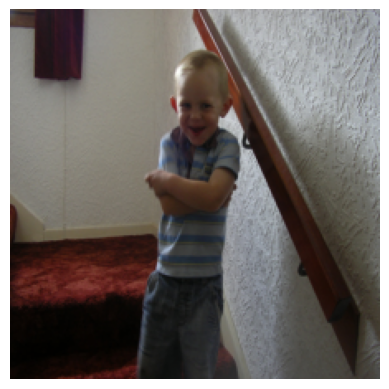

predict : A young boy in a blue shirt is standing on a bench .!!!!!!!!!!!!
real: A child is standing beside a banister on a red carpeted stair .!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [35]:
import matplotlib.pyplot as plt

images, input_ids, _ = next(iter(test_loader))
image = images[2].to(device)
input_ids = input_ids[2] 
real_caption = tokenizer.decode(input_ids, skip_special_tokens=True)


caption = generate_caption(image, model, tokenizer)
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)


image_np = image.permute(1, 2, 0).to('cpu').numpy()  


image_np = (image_np * std.numpy()) + mean.numpy()
image_np = image_np.clip(0, 1) 


plt.imshow(image_np)
plt.axis('off')  
plt.show()

print(f"predict : {caption}")

print(f"real: {real_caption}")